In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#Model Hyperparameters
RANDOM_SEED = 1 #The seed() method is used to initialize the random number generator. The random number generator needs a number to start with (a seed value), to be able to generate a random number.
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

In [ ]:
# download and transform our dataset
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ]
)

val_transform= transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
    ]
)

test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ]
)

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=train_transform,
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=test_transform,download=True)


train_idx,val_idx=random_split(train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_list=[train_dataset[i] for i in train_idx.indices]
val_list=[train_dataset[i] for i in val_idx.indices]
print("train set size :", len(train_list))
print("validation set size :",len(val_list))


train_loader = DataLoader(dataset=train_list,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader=DataLoader(dataset=val_list, batch_size=BATCH_SIZE, )

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 9912422/9912422 [00:00<00:00, 427386293.49it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 45015122.19it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 198117663.48it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 13220353.07it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

train set size : 48000
validation set size : 12000
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [ ]:
#visualization function
def visualize(num_row,num_col,images,labels):
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(10):
     ax = axes[i//num_col, i%num_col]
     ax.imshow(images[i], cmap='gray')
     ax.set_title('Label: {}'.format(labels[i]))
  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


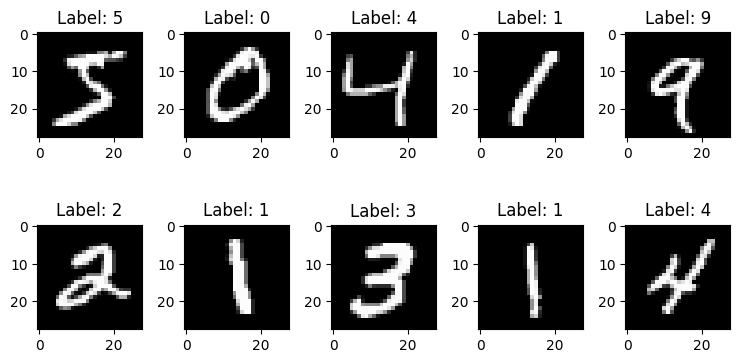

In [ ]:
#visualize a small batch of the training set
visualize(2,5,train_dataset.train_data,train_dataset.train_labels)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


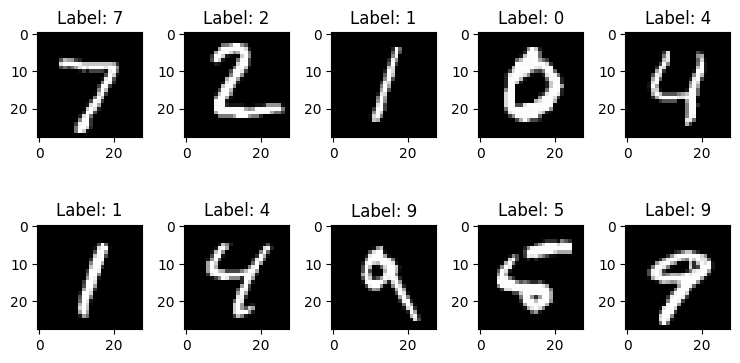

In [ ]:
#visualize a small batch of the test set
visualize(2,5,test_dataset.test_data,test_dataset.test_labels)

In [ ]:
#the model
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x




class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)



def ResNet50(num_classes, channels=1):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

def ResNet101(num_classes, channels=1):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=1):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

In [ ]:
model = ResNet50(NUM_CLASSES)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function=F.cross_entropy
torch.cuda.empty_cache()

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    predicted_labels_2d=[]
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        predicted_labels_2d.append(predicted_labels)
    return (correct_pred.float()/num_examples * 100),predicted_labels_2d

In [ ]:
#training loop
for epoch in range(20):
    # Performing Training for each epoch
    training_loss = 0.
    model.train()
    # The training loop
    for batch in train_loader:
        optimizer.zero_grad()
        input, label = batch
        input = input.to(DEVICE)
        label = label.to(DEVICE)

        output = model(input)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()


    # Performing Validation for each epoch
    validation_loss = 0.
    model.eval()

    # The validation loop
    for batch in val_loader:
        input, label = batch
        input = input.to(DEVICE)
        label = label.to(DEVICE)
        output = model(input)
        loss = loss_function(output, label)
        validation_loss += loss.item()

    # Calculating the average training and validation loss over epoch
    training_loss_avg = training_loss/len(train_loader)
    validation_loss_avg = validation_loss/len(val_loader)
    train_acc,_=compute_accuracy(model, train_loader, device=DEVICE)
    val_acc,_=compute_accuracy(model, val_loader, device=DEVICE)

    # Printing average training and average validation losses
    print("Epoch: {}".format(epoch+1))
    print("Training loss: {}".format(training_loss_avg))
    print("Validation loss: {}".format(validation_loss_avg))
    print('Epoch: %03d/%03d | Train: %.3f%%' % (epoch+1, NUM_EPOCHS, train_acc))
    print('Epoch: %03d/%03d | Val: %.3f%%' % (epoch+1, NUM_EPOCHS, val_acc))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-78c85e518897>", line 36, in <cell line: 2>
    train_acc,_=compute_accuracy(model, train_loader, device=DEVICE)
  File "<ipython-input-10-359ae84971d7>", line 9, in compute_accuracy
    probas = model(features)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "<ipython-input-8-8ab6d1f0a187>", line 95, in forward
    x = self.layer4(x)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py", line 217, in forward
    input = module(input)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module

TypeError: ignored

In [ ]:
with torch.set_grad_enabled(False): # save memory during inference
    acc,predicted_labels=(compute_accuracy(model, test_loader, device=DEVICE))
    print('Test accuracy: %.2f%%' % acc)


Test accuracy: 98.27%


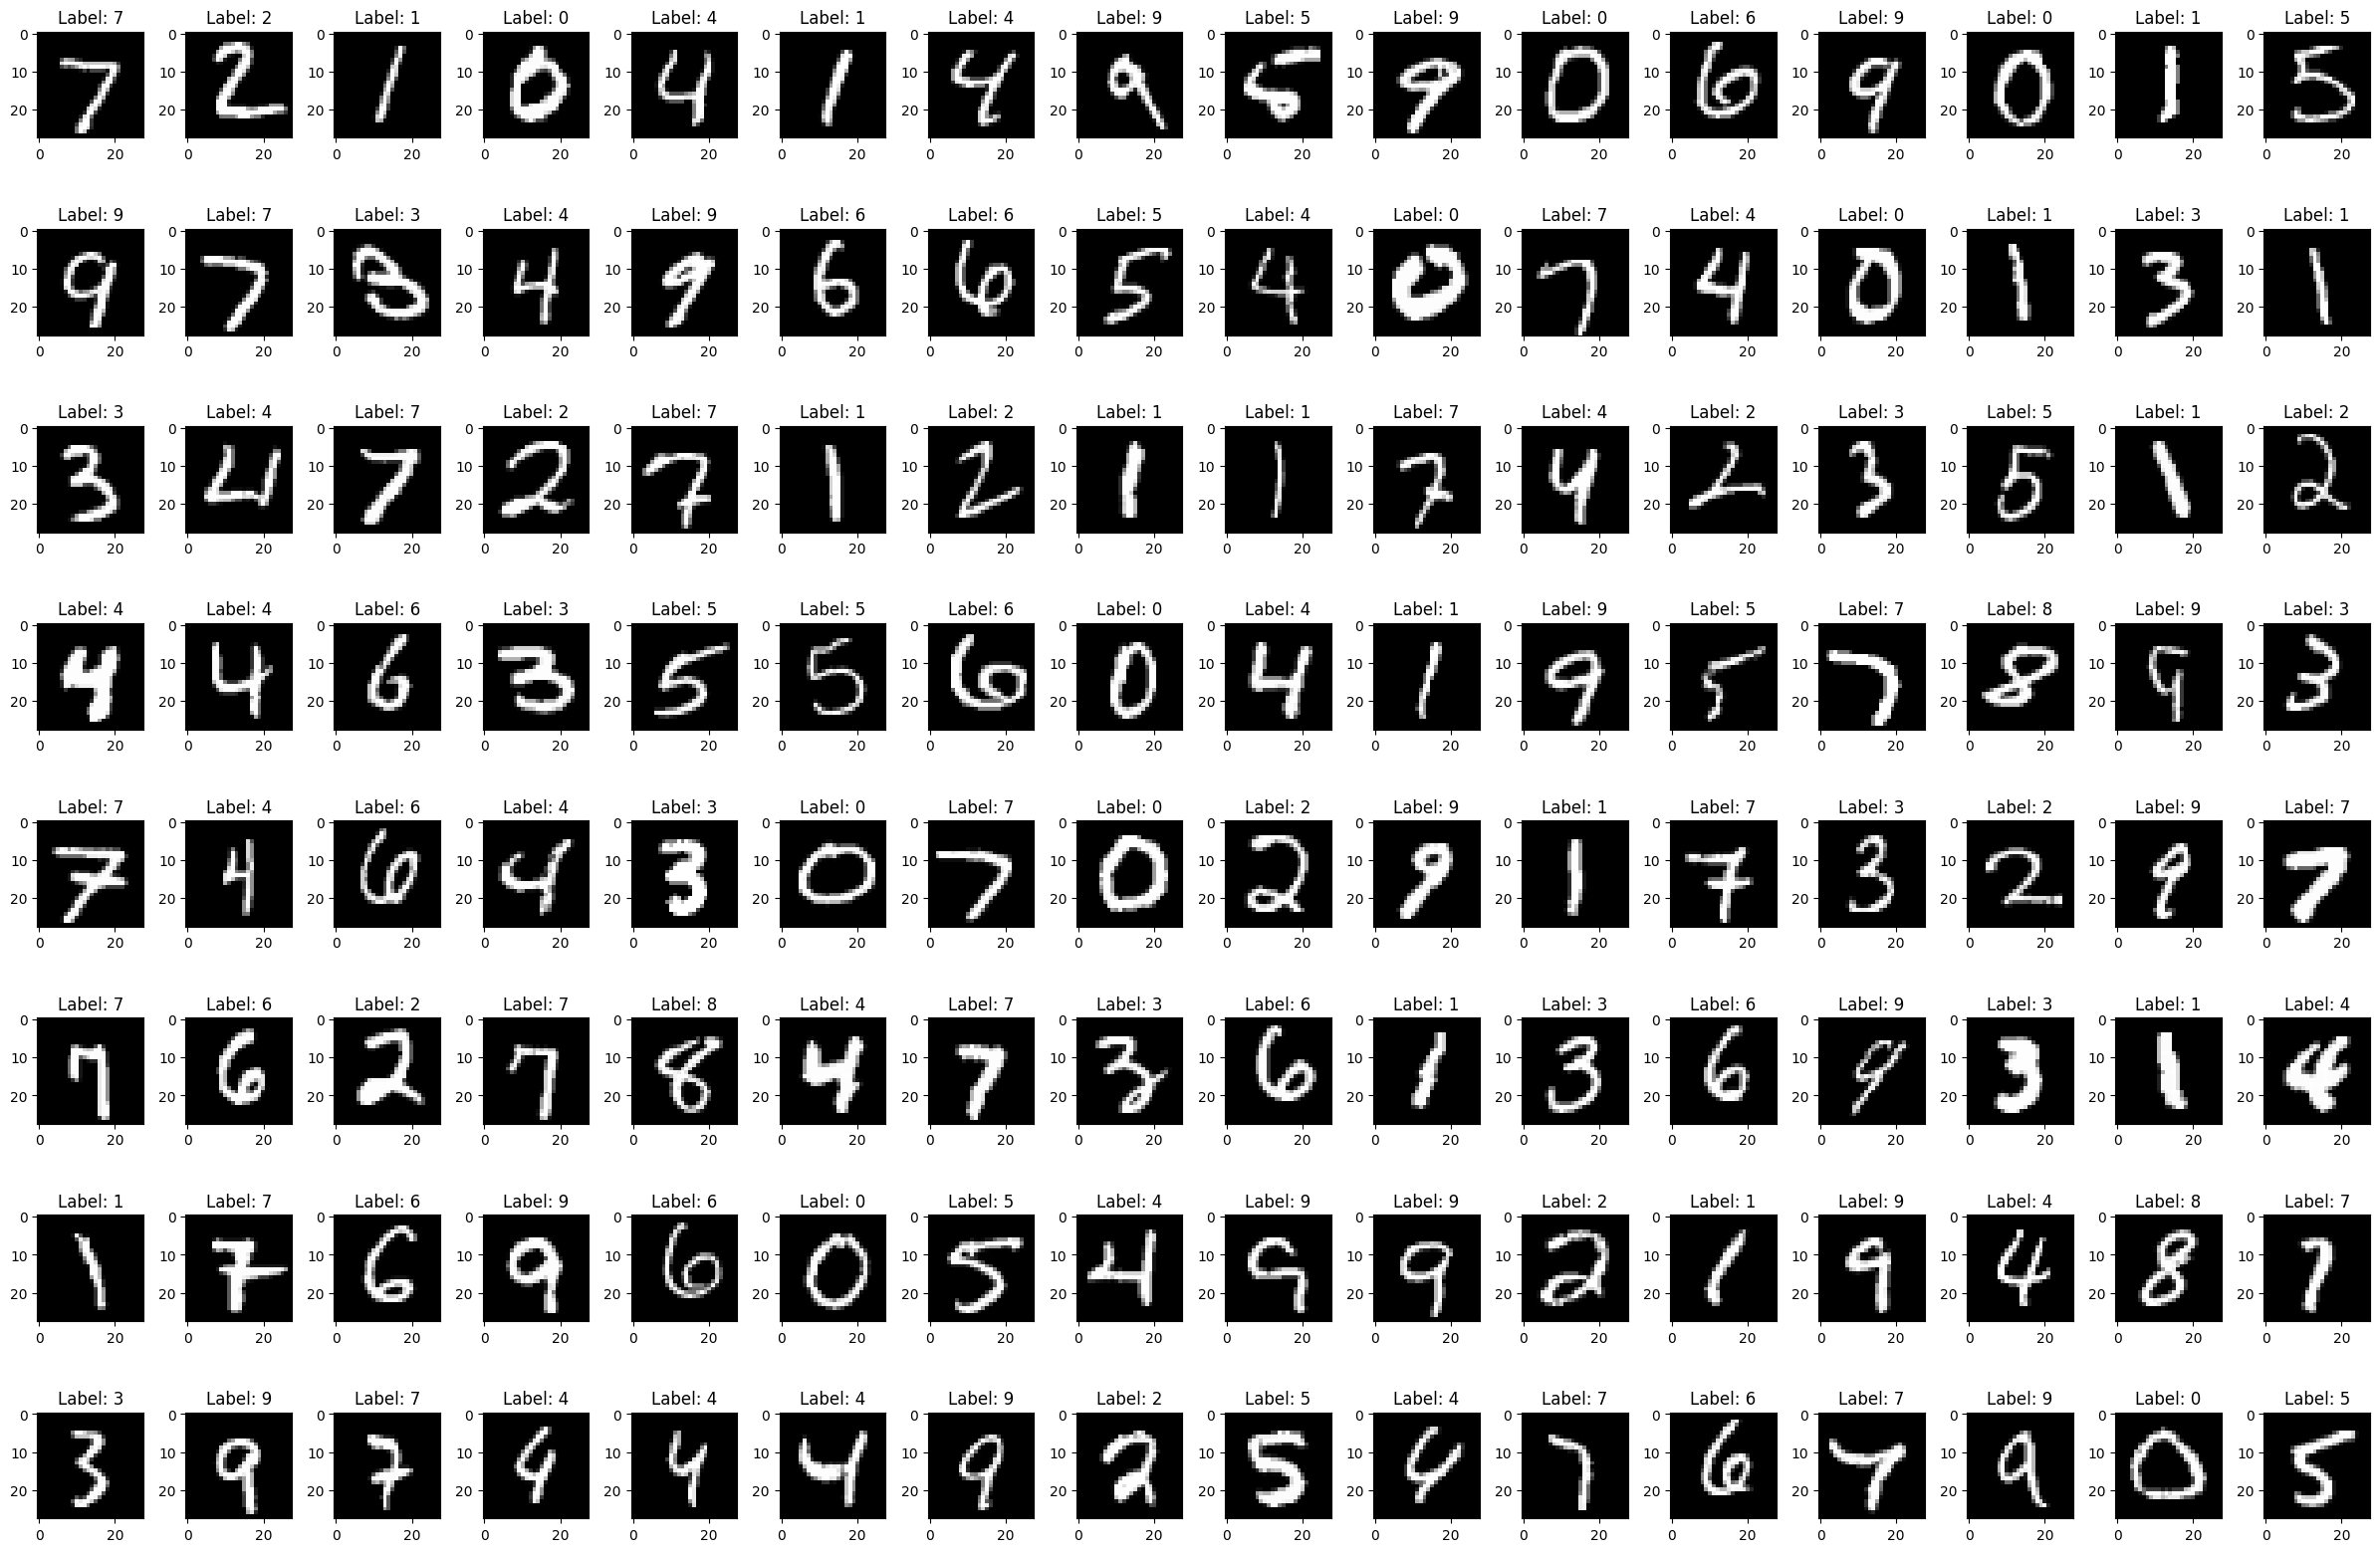

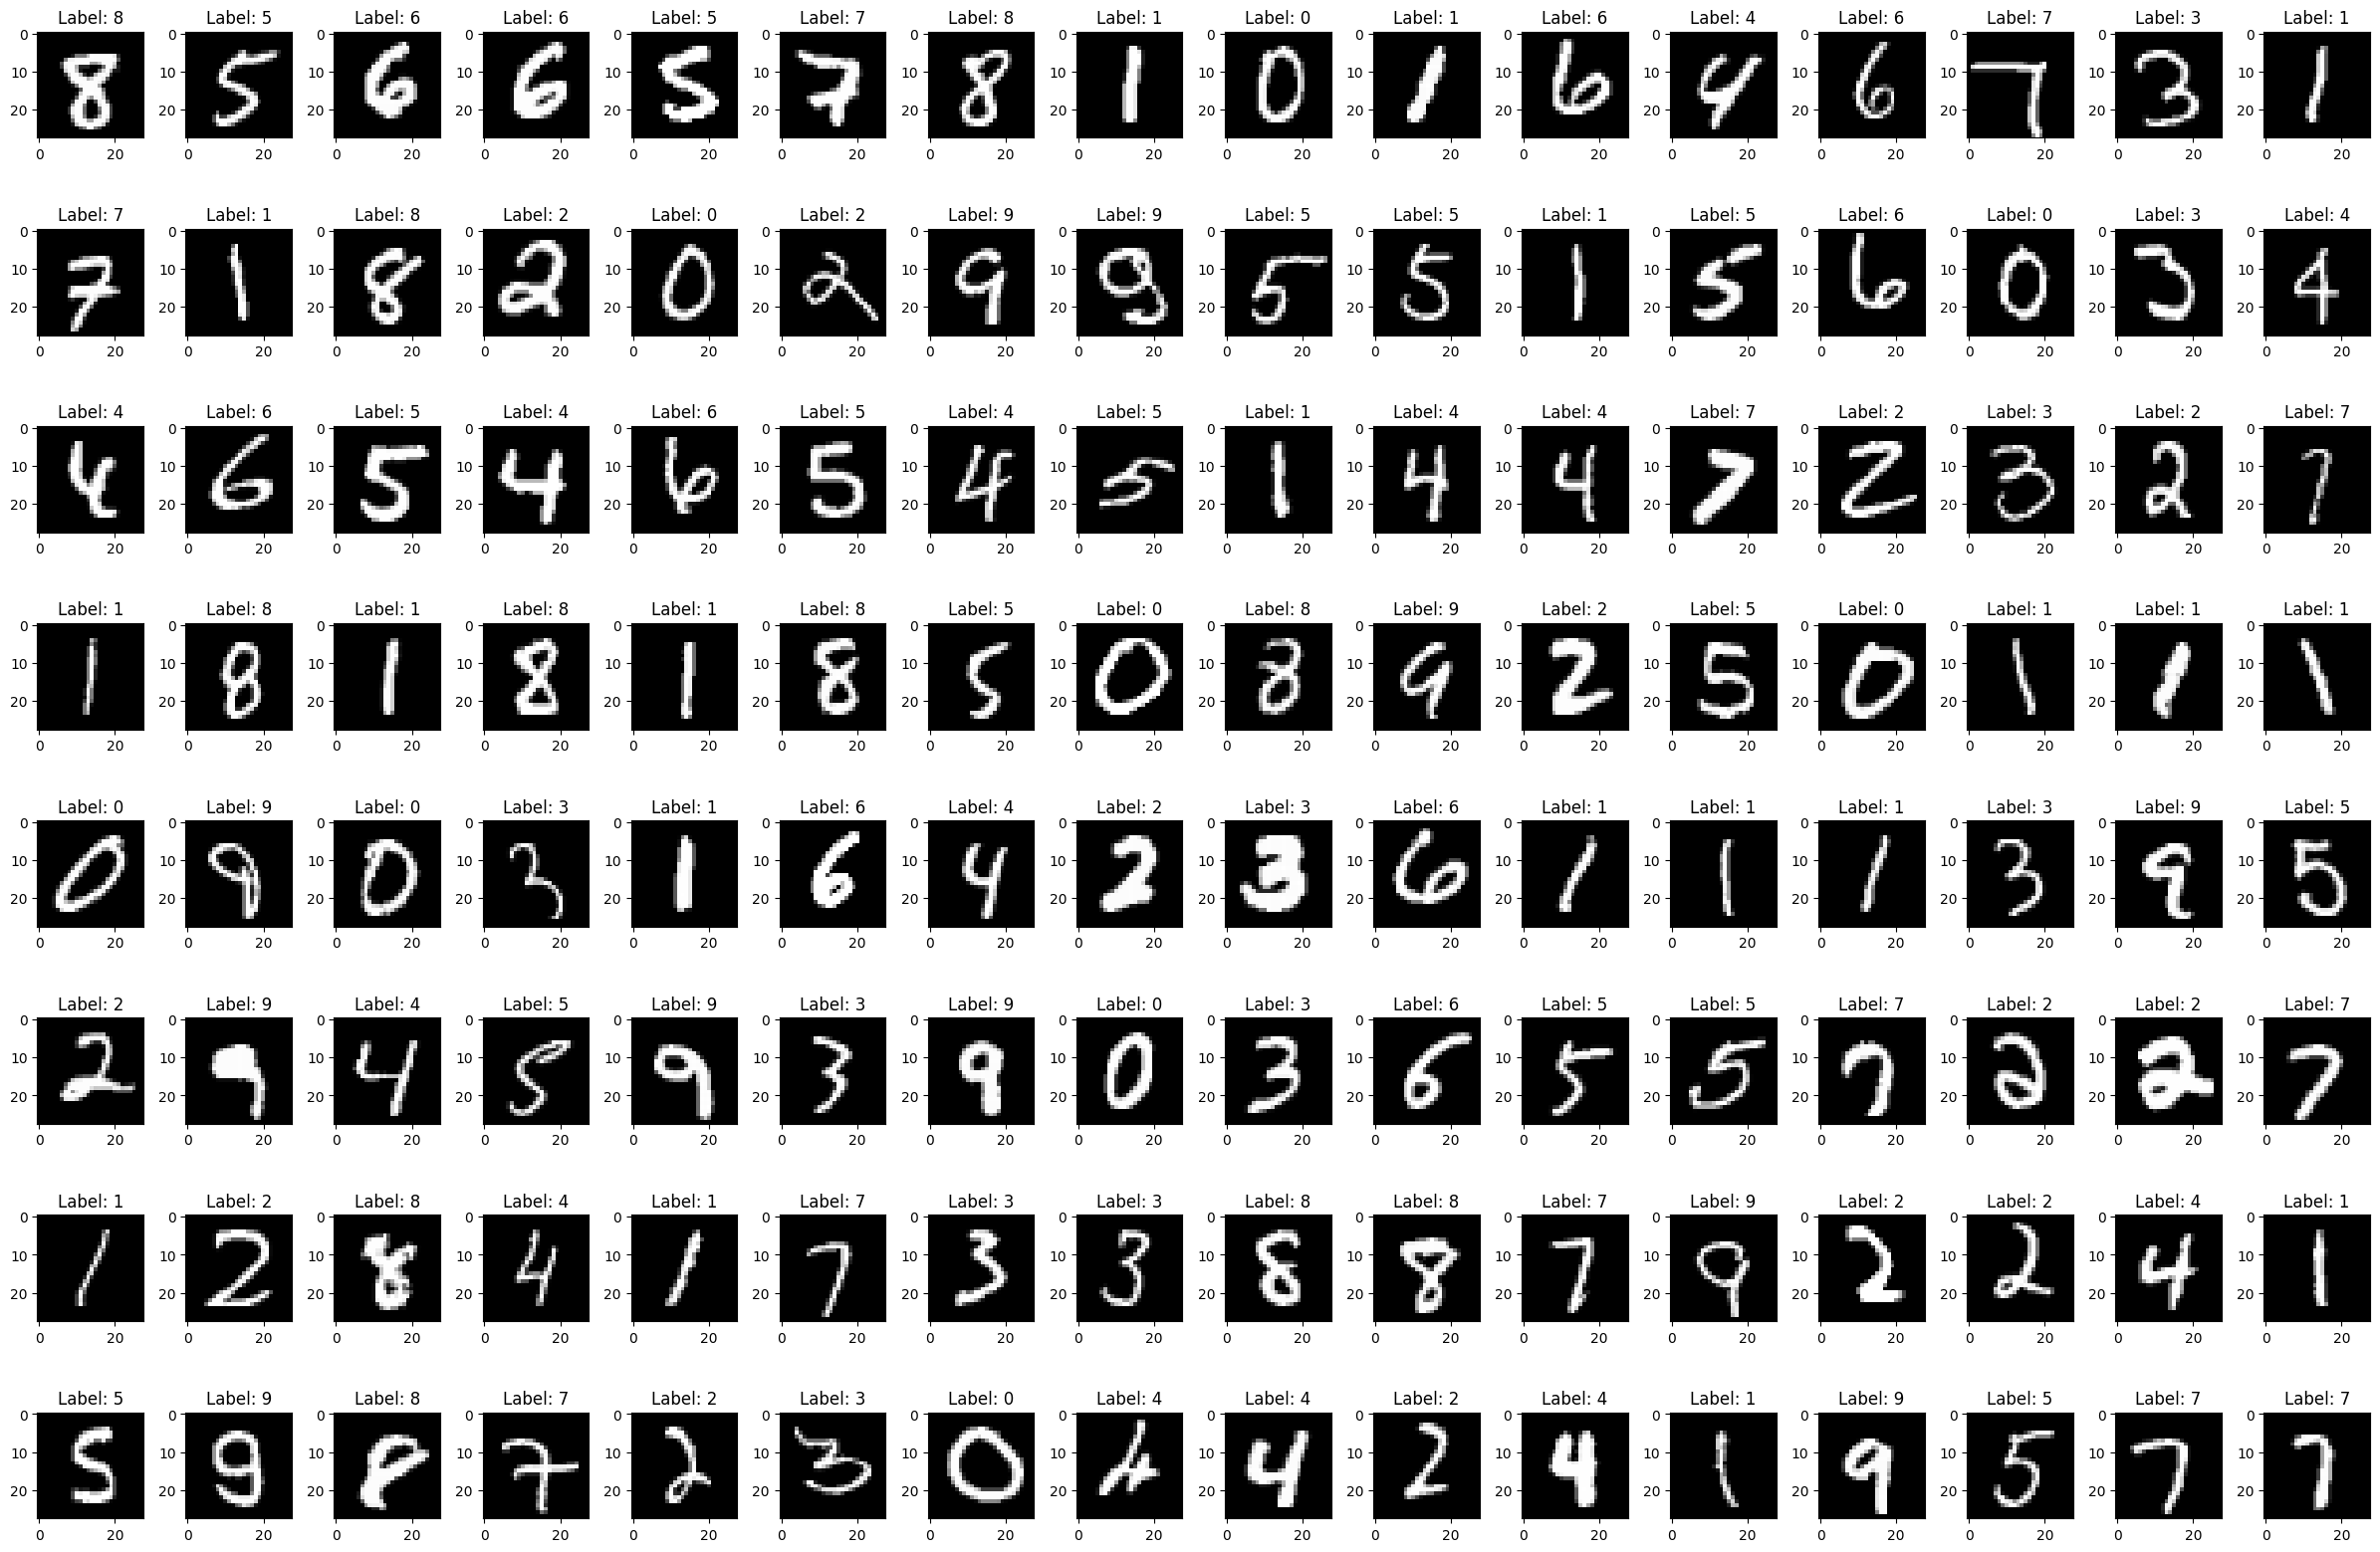

In [ ]:
o=0
for e in range(2):
  num_row = 8
  num_col = 16
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(128):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(test_dataset.test_data[o], cmap='gray')
    if predicted_labels[e].cpu().numpy()[i]!=test_dataset.test_labels[o]:
      ax.set_title('!Label: {}'.format(predicted_labels[e].cpu().numpy()[i]))
    else:
      ax.set_title('Label: {}'.format(predicted_labels[e].cpu().numpy()[i]))
    o+=1
  plt.tight_layout()
  plt.show()